# 5. Hubbard-Stratonovich transformation

This notebook discusses the discrete and continuous Hubbard-Stratonovich transformation, which trades fermionic interaction terms for (classical) auxiliary fields.

The previous notebook has demonstrated how to efficiently handle a free-fermion Hamiltonian. However, realistic or more "interesting" models (such as the Fermi-Hubbard model or a molecular Hamiltonian relevant to electronic structure theory) contain interaction terms that typically involve products of four fermionic creation and annihilation operators. The Hubbard-Stratonovich transformation maps the matrix exponential of such interaction terms to a free-fermion form, at the cost of introducing an auxiliary field. In numerical simulations, the “tracing out” of the auxiliary field is typically approximated by Monte Carlo sampling.

## 5.1 Discrete Hubbard-Stratonovich transformation

We consider a single interaction term of the form $(n_j - \frac{1}{2}) (n_k - \frac{1}{2})$, where $n_j$ is the fermionic number operator of mode (or orbital) $j$, and $j, k \in \{ 0, \dots, L-1 \}$ with $j \neq k$. Since $n_j = a_j^{\dagger} a_j$, the interaction term has weight four, i.e., requires products of four fermionic creation and annihilation operators. Our first goal is to transform the "imaginary" time evolution operator $e^{-\tau (n_j - \frac{1}{2}) (n_k - \frac{1}{2})}$, where $\tau \in \mathbb{R}$ is the imaginary time step. To simplify notation, we have absorbed the interaction strength coefficient into $\tau$.

The discrete Hubbard-Stratonovich transformation is based on the identity
\begin{equation*}
e^{-\tau (n_j - \frac{1}{2}) (n_k - \frac{1}{2})} = \frac{e^{-\tau/4}}{2} \sum_{s \in \{-1, 1\}} e^{-s \mu (n_j - n_k)}
\end{equation*}
with
\begin{equation*}
\mu = \mathrm{arccosh}(e^{\tau / 2})
\end{equation*}
and $\mathrm{arccosh}(\cdot)$ the inverse of the hyperbolic cosine. The identity can be found in (S. R. White, D. J. Scalapino, R. L. Sugar, E. Y. Loh, J. E. Gubernatis, R. T. Scalettar, Numerical study of the two-dimensional Hubbard model, [Phys. Rev. B 40, 506 (1989)](https://doi.org/10.1103/PhysRevB.40.506)). To prove it, one can first verify the equation assuming that $n_j$ and $n_k$ are scalar quantities with allowed values $0$ and $1$. The identity still holds when treating $n_j$ and $n_k$ as operators, since it holds when applying the left and right sides to a computational basis of number operator eigenstates (yielding eigenvalues $0$ or $1$ for $n_j$ and $n_k$).

Note that the right side of the above equation only contains the operator $n_j - n_k$ in the exponential, i.e., it is of free-fermion form! The summation variable $s$ corresponds to the auxiliary field. The deceptively innocent summation becomes computationally burdensome when applied to many pairwise interactions: for $K$ interaction terms, this results in $2^K$ summands. One typically approximates the overall sum by Monte Carlo sampling methods.

We verify the identity for example parameters:

In [1]:
import fermi_relations as fr
import numpy as np
from scipy.linalg import expm

In [2]:
# number of modes (or orbitals) L
nmodes = 7

# arbitrary indices and parameters
j = 2
k = 5
tau = 0.7

mu = np.arccosh(np.exp(tau / 2))

_, _, nlist = fr.construct_fermionic_operators(nmodes)

# convert to dense form for matrix exponential
nj = nlist[j].todense()
nk = nlist[k].todense()
idmat = np.identity(2**nmodes)

# reference imaginary time evolution operator
uijtau = expm(-tau * (nj - 0.5*idmat) @ (nk - 0.5*idmat))

# expression after the discrete Hubbard-Stratonovich transformation
udhstau = 0.5 * np.exp(-tau / 4) * sum(expm(-s * mu * (nj - nk)) for s in (-1, 1))

# compare
np.linalg.norm(uijtau - udhstau)

np.float64(0.0)

We can derive a "real" time evolution variant of the discrete Hubbard-Stratonovich transformation by substituting $\tau \to i t$, with $t \in \mathbb{R}$. This leads to
\begin{equation*}
e^{-i t (n_j - \frac{1}{2}) (n_k - \frac{1}{2})} = \frac{e^{-i t/4}}{2} \sum_{s \in \{-1, 1\}} e^{-i s \mu (n_j - n_k)}
\end{equation*}
with
\begin{equation*}
\mu = \mathrm{arccos}(e^{i t / 2}).
\end{equation*}
Note that $\mu$ is complex-valued in general.

In [3]:
# number of modes (or orbitals) L
nmodes = 7

# arbitrary indices and parameters
j = 1
k = 6
t = 1.3

mu = np.arccos(np.exp(0.5j * t))

_, _, nlist = fr.construct_fermionic_operators(nmodes)

# convert to dense form for matrix exponential
nj = nlist[j].todense()
nk = nlist[k].todense()
idmat = np.identity(2**nmodes)

# reference real time evolution operator
uijt = expm(-1j * t * (nj - 0.5*idmat) @ (nk - 0.5*idmat))

# expression after the discrete Hubbard-Stratonovich transformation
udhst = 0.5 * np.exp(-0.25j * t) * sum(expm(-1j * s * mu * (nj - nk)) for s in (-1, 1))

# compare
np.linalg.norm(uijt - udhst)

np.float64(1.2560739669470201e-15)

In [4]:
# The above real time evolution operator is also available as a function in 'fermi_relations':
np.linalg.norm(uijt - fr.hubbard_interaction_exponential(nmodes, j, k, t))

np.float64(0.0)

## 5.2 Continuous Hubbard-Stratonovich transformation

There exists another "continuous" Hubbard-Stratonovich transformation that is more generally applicable to an interaction term of the form $V = \frac{1}{2} b^2$, where $b$ consists of quadratic fermionic operators. This transformation involves an integral (instead of a finite sum):
\begin{equation*}
e^{-\tau b^2 / 2} = \int_{-\infty}^{\infty} \frac{e^{-\frac{x^2}{2}}}{\sqrt{2 \pi}} e^{-i x \sqrt{\tau} b} \mathrm{d}x
\end{equation*}
with $\tau \ge 0$ the "imaginary" time step, as above. This equation can be found, for example, in (Shiwei Zhang, Auxiliary-field quantum Monte Carlo
for correlated electron systems, [chapter 15](https://www.cond-mat.de/events/correl13/manuscripts/zhang.pdf) in: Emergent Phenomena in Correlated Matter
Modeling and Simulation, Vol. 3, Verlag des Forschungszentrums Jülich (2013)). Note that the exponent on the right is _linear_ in $b$, analogous to $n_j - n_k$ for the discrete version above.

Identifying the factor $\frac{e^{-\frac{x^2}{2}}}{\sqrt{2 \pi}}$ in the integrand as the density of the standard normal distribution, we can interpret the integral on the right as an expectation value with respect to a normally distributed random variable $x$:
\begin{equation*}
\int_{-\infty}^{\infty} \frac{e^{-\frac{x^2}{2}}}{\sqrt{2 \pi}} e^{-i x \sqrt{\tau} b} \mathrm{d}x = \mathbb{E}_{x \sim \mathcal{N}(0, 1)}[e^{-i x \sqrt{\tau} b}].
\end{equation*}
Thus, a natural approach to approximate the integral is by Monte Carlo sampling. This becomes particularly relevant when many (nested) integrals of this form arise from a sum of interaction terms over several time steps.

We verify the "continuous" Hubbard-Stratonovich transformation for example parameters, using the Gauss-Hermite quadrature rule to numerically evaluate the integral:

In [5]:
# random number generator
rng = np.random.default_rng(46)

In [6]:
# number of modes (or orbitals) L
nmodes = 7

clist, alist, _ = fr.construct_fermionic_operators(nmodes)

# random single-particle coefficient matrix (not necessarily Hermitian)
b = 0.5 * fr.crandn((nmodes, nmodes), rng)
# free-fermion operator on the whole Fock space
bfock = sum(b[i, j] * (clist[i] @ alist[j])
            for i in range(nmodes)
            for j in range(nmodes)).toarray()

# squared operator
vfock = 0.5 * (bfock @ bfock)

In [7]:
# imaginary time step
tau = 0.4

# reference time evolution operator
utau_ref = expm(-tau * vfock)

# continuous Hubbard-Stratonovich transformation
points, weights = fr.gauss_hermite_quadrature(20)
utau = sum(w * expm(-1j * x * np.sqrt(tau) * bfock) for x, w in zip(points, weights))

# compare
np.linalg.norm(utau - utau_ref)

np.float64(6.578309916480485e-14)

The analogous "real" time evolution variant reads, for time $t \in \mathbb{R}$:
\begin{equation*}
e^{-i t b^2 / 2} = \int_{-\infty}^{\infty} \frac{e^{-\frac{x^2}{2}}}{\sqrt{2 \pi}} e^{\sqrt{-i} x \sqrt{t} b} \mathrm{d}x.
\end{equation*}

In [8]:
# real time step
t = 0.3

# reference time evolution operator
ut_ref = expm(-1j * t * vfock)

# continuous Hubbard-Stratonovich transformation
phase = np.exp(-1j * np.pi / 4)
points, weights = fr.gauss_hermite_quadrature(20)
ut = sum(w * expm(phase * x * np.sqrt(t) * bfock) for x, w in zip(points, weights))

# compare
np.linalg.norm(ut - ut_ref)

np.float64(6.797876676319222e-15)

The Gauss-Hermite quadrature converges exponentially with respect to the number of quadrature points:

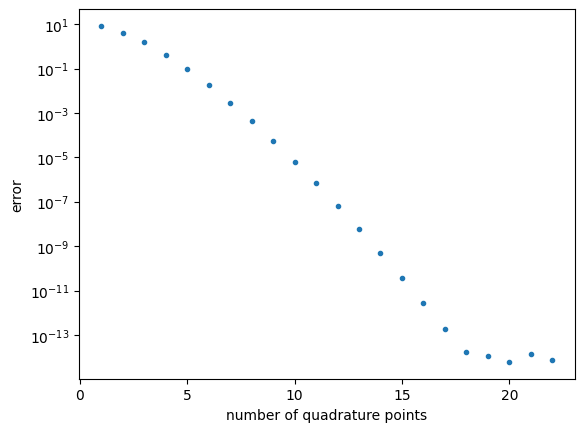

In [9]:
import matplotlib.pyplot as plt

err_list = []
# number of quadrature points
nlist = range(1, 23)
for n in nlist:
    # continuous Hubbard-Stratonovich transformation
    phase = np.exp(-1j * np.pi / 4)
    points, weights = fr.gauss_hermite_quadrature(n)
    ut = sum(w * expm(-phase * x * np.sqrt(t) * bfock) for x, w in zip(points, weights))
    err_list.append(np.linalg.norm(ut - ut_ref))
plt.semilogy(nlist, err_list, '.')
plt.xlabel("number of quadrature points")
plt.ylabel("error")
plt.show()